In [1]:
import regex as re
import numpy as np
from statistics import mean, stdev
import matplotlib
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from bento_bench import bar_plot, parse_elapsed_secs, get_avg_from_table_str, set_size
import pandas as pd
import json
import os
import seaborn as sns
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': False,
#     'pgf.rcfonts': False,
    "font.size": 15,
})

fio_iops_avg_regex = "(?<=^\s*iops\s*: min=\s*\d*, max=\s*\d*, avg=\s*)\d+\.\d*"
fio_iops_stdev_regex = "(?<=^\s*iops\s*: min=\s*\d*, max=\s*\d*, avg=\s*\d*\.*\d*, stdev=\s*)\d+\.\d*"

# Some are in KiB, some in MiB....
fio_bw_kib_avg_regex = "(?<=^\s*bw \(  KiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*)\d+\.\d*"
fio_bw_mib_avg_regex = "(?<=^\s*bw \(  MiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*)\d+\.\d*"
fio_bw_mib_avg_regex_alt = "(?<=BW=)\d+\.*\d*"
fio_bw_kib_stdev_regex = "(?<=^\s*bw \(  KiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*\d*\.*\d*, stdev=\s*)\d+\.\d*"
fio_bw_mib_stdev_regex = "(?<=^\s*bw \(  MiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*\d*\.*\d*, stdev=\s*)\d+\.\d*"

fio_clat_usec_avg_regex = "(?<=^\s*clat \(usec\): min=\d+, max=\d+\.*\d*k*M*, avg=\s*)\d+\.\d*"
fio_clat_nsec_avg_regex = "(?<=^\s*clat \(nsec\): min=\d+, max=\d+\.*\d*k*M*, avg=\s*)\d+\.\d*"
fio_clat_usec_stdev_regex = "(?<=^\s*clat \(usec\): min=\d+, max=\d+\.*\d*k*M*, avg=\d+\.*\d*, stdev=\s*)\d+\.\d*"
fio_clat_nsec_stdev_regex = "(?<=^\s*clat \(nsec\): min=\d+, max=\d+\.*\d*k*M*, avg=\d+\.*\d*, stdev=\s*)\d+\.\d*"

In [2]:
def get_instructions(df):
    return df.loc[df['event'] == 'instructions', ['val']].iloc[0].item()
def get_cpus(df):
    return df.loc[df['event'] == 'cpu-clock', ['metric_val']].iloc[0].item()
def get_cycles(df):
    return df.loc[df['event'] == 'cycles', ['val']].iloc[0].item()
# We assume here that all the events have been measured for an equal amount of time
def get_time_measured(df):
    return df.loc[df['event'] == 'cpu-clock', ['time_measured']].iloc[0].item() / get_cpus(df)
def get_ipc(df):
    return df.loc[df['event'] == 'instructions', ['metric_val']].iloc[0].item()
def get_branches(df):
    return df.loc[df['event'] == 'branches', ['val']].iloc[0].item()
def get_branch_missrate(df):
    return df.loc[df['event'] == 'branch-misses', ['metric_val']].iloc[0].item()
def get_val(df, metric):
    return df.loc[df['event'] == metric, ['val']].iloc[0].item()
def get_l1_dcache_missrate(df):
    return df.loc[df['event'] == 'L1-dcache-load-misses', ['metric_val']].iloc[0].item()
def get_dtlb_missrate(df):
    return df.loc[df['event'] == 'dTLB-loads-misses', ['metric_val']].iloc[0].item()

In [3]:
perf_stat_colnames = [ "val", "unit", "event", "time_measured", "perctage_measured", "metric_val", "metric_unit"]
targets = {
    "NFS": "./nfs/",
    "Virtio-fs": "./vnfs/",
    "nulldev": "./nulldev/"
}
metrics = ["Instructions/OP", "IPC", "Branch missrate", "L1 dCache missrate", "dTLB missrate"]
# perf time_measured is in nsec
runtime = 600
perf_nrep = 5

perf_load = []
iops = []
table = pd.DataFrame(index=metrics)
for i, (conf, folder) in enumerate(targets.items()):
    T1_iops_l = pd.Series(dtype="float")
    for i in range(1, perf_nrep+1):
        f = open(folder + "cpu_load_T1_fio_" + str(i) + ".out")
        matches = re.findall(fio_iops_avg_regex, f.read(), re.MULTILINE)
        T1_iops_l = pd.concat((T1_iops_l, pd.Series(np.array(matches).astype(float).sum())))
    T1_iops = T1_iops_l.mean()

    perf_baseline = pd.DataFrame(columns=["instructions"])
    for i in range(1, perf_nrep+1):
        f = open(folder + "cpu_baseline_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        f.readline()
        f.readline()
        raw = pd.read_csv(f, names=perf_stat_colnames)
        row = {
            "instructions": get_instructions(raw)
        }
        perf_baseline = pd.concat((perf_baseline, pd.DataFrame([row])), ignore_index=True)

    perf_load = pd.DataFrame(columns=["instructions", "ipc", "branch_missrate"])
    for i in range(1, perf_nrep+1):
        T1_f = open(folder + "cpu_load_T1_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T1_f.readline()
        T1_f.readline()
        T1_raw = pd.read_csv(T1_f, names=perf_stat_colnames)
        T2_f = open(folder + "cpu_load_T2_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T2_f.readline()
        T2_f.readline()
        T2_raw = pd.read_csv(T2_f, names=perf_stat_colnames)
        T3_f = open(folder + "cpu_load_T3_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T3_f.readline()
        T3_f.readline()
        T3_raw = pd.read_csv(T3_f, names=perf_stat_colnames)
        row = {
            "instructions": get_instructions(T1_raw),
            "ipc": get_ipc(T1_raw),
            "branch_missrate": get_branch_missrate(T1_raw),
            "l1": get_l1_dcache_missrate(T2_raw),
            "dtlb": get_dtlb_missrate(T3_raw),
        }
        perf_load = pd.concat((perf_load, pd.DataFrame([row])), ignore_index=True)

    perf_baseline = perf_baseline.mean()
    perf_load = perf_load.mean()
    
    row = {
        metrics[0]: round((perf_load[0] - perf_baseline[0]) / runtime / T1_iops),
        metrics[1]: perf_load[1],
        metrics[2]: perf_load[2],
        metrics[3]: perf_load[3],
        metrics[4]: perf_load[4]
    }
    table = table.join(pd.DataFrame([row]).transpose())
    table = table.rename(columns={ 0: conf })

table['+/- %'] = (table['NFS'] - table['Virtio-fs']) / table['NFS'] * 100 * -1
table['+/- % 2'] = (table['NFS'] - table['nulldev']) / table['NFS'] * 100 * -1
    
table = table.round(2).applymap("{0:.2f}".format)
print(table)
table.style.to_latex("cpu_analysis.tex", hrules=True)

                         NFS Virtio-fs   nulldev   +/- % +/- % 2
Instructions/OP     88453.00  32907.00  16520.00  -62.80  -81.32
IPC                     0.57      0.94      0.59   64.21    2.81
Branch missrate         2.02      1.06      1.14  -47.42  -43.45
L1 dCache missrate      8.82      3.82      4.19  -56.65  -52.46
dTLB missrate           0.14      0.15      0.20    7.35   50.00


In [4]:
cols = ["conf", "RW", "BS", "QD", "P", "IOPS_avg", "IOPS_stdev", "clat_avg", "clat_stdev", "bw_avg", "bw_stdev"]

def parse_fio(RW, BS, QD, P, conf, folder):
    df = pd.DataFrame(columns=cols)
    
    for rw in RW:
        for bs in BS:
            for qd in QD:
                for p in P:
                    path = "fio_" + rw + "_" + bs + "_" + qd + "_" + p + ".out"
                    f = open(folder + path)
                    f_buf = f.read()

                    # IOPS
                    avg_matches = re.findall(fio_iops_avg_regex, f_buf, re.MULTILINE)
                    stdev_matches = re.findall(fio_iops_stdev_regex, f_buf, re.MULTILINE)
                    row = {
                        "conf": conf,
                        "RW": rw,
                        "BS": bs,
                        "QD": qd,
                        "P": p,
                        "IOPS_avg": np.array(avg_matches).astype(float)[0],
                        "IOPS_stdev": np.array(stdev_matches).astype(float)[0]
                    }

                    # Completion latency
                    avg_matches = np.array(re.findall(fio_clat_usec_avg_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(avg_matches) == 0):
                        avg_matches = np.array(re.findall(fio_clat_nsec_avg_regex, f_buf, re.MULTILINE)).astype(float)
                        avg_matches = avg_matches / 1000.0 # convert to usec

                    stdev_matches = np.array(re.findall(fio_clat_usec_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(stdev_matches) == 0):
                        stdev_matches = np.array(re.findall(fio_clat_nsec_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                        stdev_matches = stdev_matches / 1000.0 # convert to usec

                    row["clat_avg"] = np.array(avg_matches).astype(float)[0]
                    row["clat_stdev"] = np.array(stdev_matches).astype(float)[0]

                    # Bandwidth
                    avg_matches = np.array(re.findall(fio_bw_mib_avg_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(avg_matches) == 0):
                        avg_matches = np.array(re.findall(fio_bw_kib_avg_regex, f_buf, re.MULTILINE)).astype(float)
                        avg_matches = avg_matches / 1024.0 # convert to MiB
                    if int(p) > 2:
                        avg_matches = np.array(re.findall(fio_bw_mib_avg_regex_alt, f_buf, re.MULTILINE)).astype(float)
                        

                    stdev_matches = np.array(re.findall(fio_bw_mib_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(stdev_matches) == 0):
                        stdev_matches = np.array(re.findall(fio_bw_kib_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                        stdev_matches = stdev_matches / 1024.0 # convert to MiB

                    row["bw_avg"] = np.array(avg_matches).astype(float)[0]
                    row["bw_stdev"] = np.array(stdev_matches).astype(float)[0]

                    df = pd.concat((df, pd.DataFrame([row])), ignore_index=True)
                
    return df

In [5]:
targets = {
    "NFS": "./nfs/",
    "VNFS": "./vnfs/",
    "nulldev": "./nulldev/"
}

s = pd.DataFrame(columns=cols)

# Throughput & BW
for (conf, folder) in targets.items():
    df = parse_fio(["randread", "randwrite"], ["1", "4k", "8k", "16k", "32k", "64k", "128k"],
                   ["1", "2", "4", "8", "16", "32", "64", '128'], # '128
                   ["2"], conf, folder)
    s = pd.concat((s, df), ignore_index=True)

# Mutli-core
for (conf, folder) in targets.items():
    df = parse_fio(["randread", "randwrite"], ["4k", "32k"],
                   ["128"],
                   ["1", "4", "8"], conf, folder) # '2' is already loaded
    s = pd.concat((s, df), ignore_index=True)
    
# Latency
for (conf, folder) in targets.items():
    df = parse_fio(["randread", "randwrite"], ["1", "4k", "8k", "16k", "32k", "64k", "128k"],
                   ["1"],
                   ["1"], conf, folder)
    s = pd.concat((s, df), ignore_index=True)

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/1813564576.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/1813564576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_data['bw_avg'] = tp_data['bw_avg'] / 1024.0
/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/1813564576.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

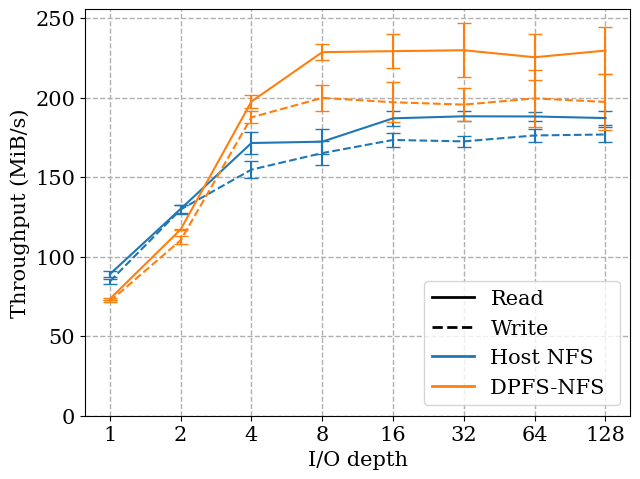

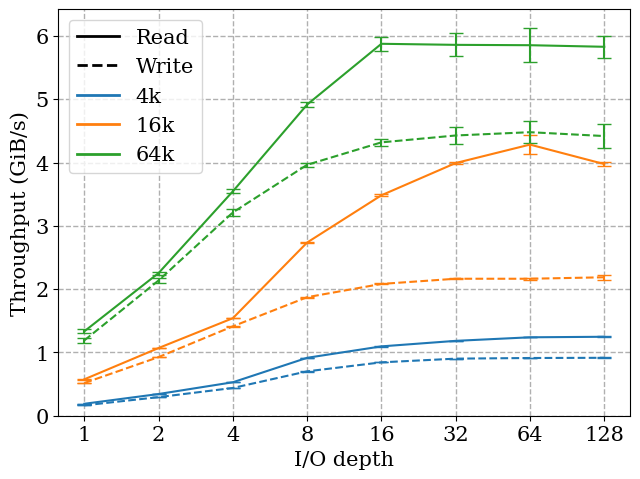

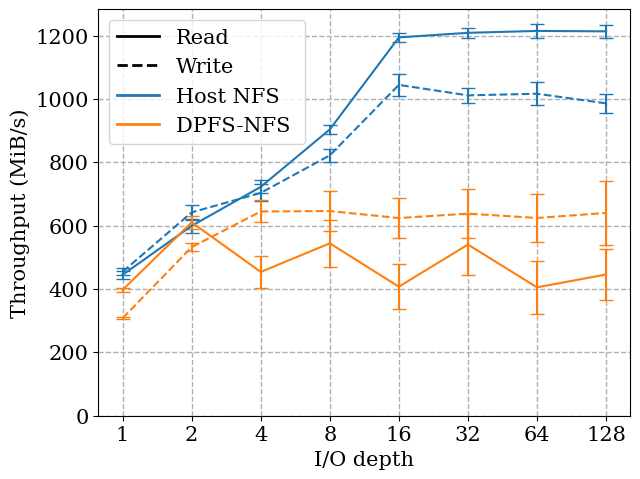

In [6]:
# Throughput

def plot_tp(confs, BS, BS_colormap, conf_colormap, GiB, file):
    fig, ax = plt.subplots()

    P = '2'

    x = s.loc[(s['RW'] == 'randread') & (s['BS'] == BS[0]) & (s['P'] == P) & (s['conf'] == list(confs.keys())[0]), 'QD']
    for (conf, conf_name) in confs.items():
        for bs in BS:
            tp_data = s.loc[(s['BS'] == bs) & (s['conf'] == conf) & (s['P'] == P)]
            if GiB:
                tp_data['bw_avg'] = tp_data['bw_avg'] / 1024.0
                tp_data['bw_stdev'] = tp_data['bw_stdev'] / 1024.0
                

            color = None
            if BS_colormap is not None:
                color = BS_colormap[bs]
            elif conf_colormap is not None:
                color = conf_colormap[conf]
            ax.errorbar(x, tp_data.loc[(tp_data['RW'] == 'randread'), 'bw_avg'], tp_data.loc[(tp_data['RW'] == 'randread'), 'bw_stdev'],
                        markersize=4, linestyle='-', label=conf_name + "read " + bs, capsize=5, capthick=1, color=color)
            ax.errorbar(x, tp_data.loc[(tp_data['RW'] == 'randwrite'), 'bw_avg'], tp_data.loc[(tp_data['RW'] == 'randwrite'), 'bw_stdev'],
                        markersize=4, linestyle='--', label=conf_name + "write " + bs, capsize=5, capthick=1, color=color)

    fig.tight_layout()
    ax.grid(which='major', linestyle='dashed', linewidth='1')
    ax.set_axisbelow(True)
    ax.legend(loc='best')
    ax.set_ylim(bottom=0)
    if GiB:
        ax.set_ylabel("Throughput (GiB/s)")
    else:
        ax.set_ylabel("Throughput (MiB/s)")
    ax.set_xlabel("I/O depth")
    
    legend_dict = {'Read': Line2D([0], [0], color='black', linestyle='-', lw=2),
                   'Write': Line2D([0], [0], color='black', linestyle='--', lw=2)}
    if BS_colormap is not None:
        for (k, v) in BS_colormap.items():
            legend_dict[k] = Line2D([0], [0], color=v, lw=2)
    if conf_colormap is not None:
        for (k, v) in conf_colormap.items():
            legend_dict[confs[k]] = Line2D([0], [0], color=v, lw=2)
    
    ax.legend(legend_dict.values(), legend_dict.keys(), loc='best')

    fig.show()
    plt.savefig("./graphs/" + file + "_tp.pdf", bbox_inches="tight")
    
plot_tp({'NFS': 'Host NFS ', 'VNFS': 'DPFS-NFS '}, ['4k'], None,
        {'NFS': 'tab:blue', 'VNFS': 'tab:orange'}
        , False, 'nfs_vnfs')
plot_tp({'nulldev': ''}, ['4k', '16k', '64k'],
        #None,
        {'4k': 'tab:blue', '16k': 'tab:orange', '64k': 'tab:green'},
        None, True, 'nulldev')
plot_tp({'NFS': 'Host NFS ', 'VNFS': 'DPFS-NFS '}, ['32k'], None,
        {'NFS': 'tab:blue', 'VNFS': 'tab:orange'}
        , False, 'nfs_vnfs_large')

In [7]:
print(s.loc[(s['RW'] == 'randread') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '16') & (s['BS'] == '64k'), 'bw_avg'] / 1024.0)
print(s.loc[(s['RW'] == 'randwrite') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '16') & (s['BS'] == '64k'), 'bw_avg'] / 1024.0)
print(s.loc[(s['RW'] == 'randread') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '128') & (s['BS'] == '4k'), 'bw_avg'])
print(s.loc[(s['RW'] == 'randwrite') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '128') & (s['BS'] == '4k'), 'bw_avg'])
print(s.loc[(s['RW'] == 'randread') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '128') & (s['BS'] == '4k'), 'IOPS_avg'] / 1000)
print(s.loc[(s['RW'] == 'randwrite') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '128') & (s['BS'] == '4k'), 'IOPS_avg'] / 1000)
print(s.loc[(s['RW'] == 'randread') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '1') & (s['BS'] == '4k'), 'bw_avg'])
print(s.loc[(s['RW'] == 'randwrite') & (s['P'] == '2') & (s['conf'] == 'nulldev') & (s['QD'] == '1') & (s['BS'] == '4k'), 'bw_avg'])

268    5.879678
Name: bw_avg, dtype: float64
324    4.321494
Name: bw_avg, dtype: float64
239    1278.03
Name: bw_avg, dtype: float64
295    937.550762
Name: bw_avg, dtype: float64
239    327.17462
Name: IOPS_avg, dtype: float64
295    240.01293
Name: IOPS_avg, dtype: float64
232    193.286963
Name: bw_avg, dtype: float64
288    167.901543
Name: bw_avg, dtype: float64


In [8]:
nfs = s.loc[(s['RW'].isin(['randread', 'randwrite'])) & (s['P'] == '2') & (s['conf'] == 'NFS') & (s['QD'].isin(['1', '2'])) & (s['BS'] == '4k'), 'bw_avg'].reset_index()
vnfs = s.loc[(s['RW'].isin(['randread', 'randwrite'])) & (s['P'] == '2') & (s['conf'] == 'VNFS') & (s['QD'].isin(['1', '2'])) & (s['BS'] == '4k'), 'bw_avg'].reset_index()
print(nfs/vnfs)
nfs = s.loc[(s['RW'].isin(['randread', 'randwrite'])) & (s['P'] == '2') & (s['conf'] == 'NFS') & (s['QD'].isin(['4', '8', '16', '32', '64', '128'])) & (s['BS'] == '4k'), 'bw_avg'].reset_index()
vnfs = s.loc[(s['RW'].isin(['randread', 'randwrite'])) & (s['P'] == '2') & (s['conf'] == 'VNFS') & (s['QD'].isin(['4', '8', '16', '32', '64', '128'])) & (s['BS'] == '4k'), 'bw_avg'].reset_index()
print(vnfs/nfs)

      index    bw_avg
0  0.066667  1.212086
1  0.074380  1.110074
2  0.363636  1.173280
3  0.367232  1.175540
        index    bw_avg
0   12.200000  1.152296
1   11.181818  1.326733
2   10.333333  1.225839
3    9.615385  1.220614
4    9.000000  1.197938
5    8.466667  1.226685
6    2.696970  1.212533
7    2.671642  1.210111
8    2.647059  1.136782
9    2.623188  1.134019
10   2.600000  1.132143
11   2.577465  1.115783


/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/751818852.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


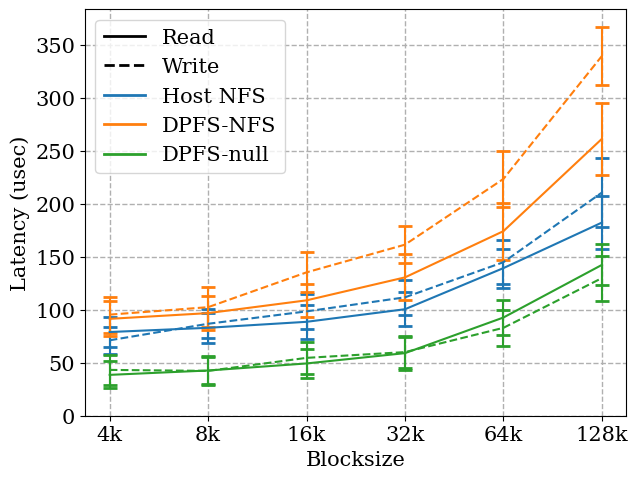

In [9]:
# Latency
# TODO test with P=1

def plot_latency(confs, P, conf_colormap, ylim, file):
    fig, ax = plt.subplots()

    QD = '1'

    x = s.loc[(s['RW'] == 'randread') & (s['P'] == P) & (s['conf'] == list(confs.keys())[0]) & (s['QD'] == QD) & (s['BS'] != '1'), 'BS']

    for (conf, conf_name) in confs.items():
        clat_data = s.loc[(s['QD'] == QD) & (s['conf'] == conf) & (s['P'] == P) & (s['BS'] != '1')]
        
        color = None
        if conf_colormap is not None:
            color = conf_colormap[conf]
        ax.errorbar(x, clat_data.loc[(clat_data['RW'] == 'randread'), 'clat_avg'], clat_data.loc[(clat_data['RW'] == 'randread'), 'clat_stdev'],
                    markersize=6, linestyle='-', label=conf_name + " read", capsize=5, capthick=2, color=color)
        ax.errorbar(x, clat_data.loc[(clat_data['RW'] == 'randwrite'), 'clat_avg'], clat_data.loc[(clat_data['RW'] == 'randwrite'), 'clat_stdev'],
                    markersize=6, linestyle='--', label=conf_name + " write", capsize=5, capthick=2, color=color)


    fig.tight_layout()
    ax.grid(which='major', linestyle='dashed', linewidth='1')
    ax.set_axisbelow(True)
    ax.set_ylim(bottom=0, top=ylim)
    ax.set_ylabel("Latency (usec)")
    ax.set_xlabel("Blocksize")
    
    legend_dict = {'Read': Line2D([0], [0], color='black', linestyle='-', lw=2),
                   'Write': Line2D([0], [0], color='black', linestyle='--', lw=2)}
    
    if conf_colormap is not None:
        for (k, v) in conf_colormap.items():
            legend_dict[confs[k]] = Line2D([0], [0], color=v, lw=2)
    ax.legend(legend_dict.values(), legend_dict.keys(), loc='best')

    fig.show()
    plt.savefig("./graphs/" + file + "_clat.pdf", bbox_inches="tight")

plot_latency({'NFS': 'Host NFS', 'VNFS': 'DPFS-NFS', 'nulldev': 'DPFS-null'}, '1', 
             {'NFS': 'tab:blue', 'VNFS': 'tab:orange', 'nulldev': 'tab:green'},
             None, 'nfs_vnfs_null')

#plot_latency({'nulldev': 'DPFS-null'}, '1', None, 'nulldev')


/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/3499104462.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


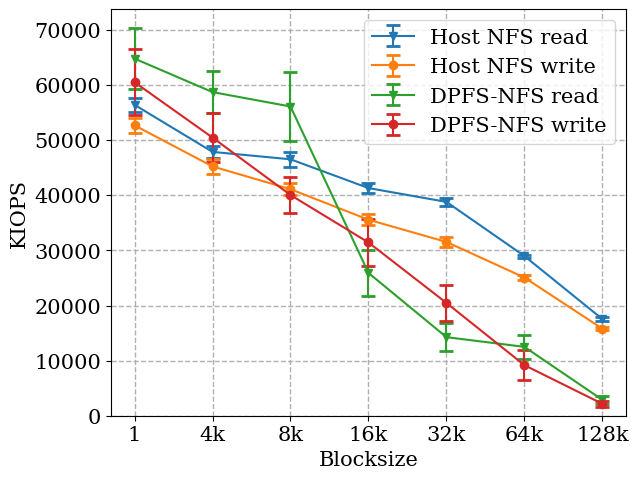

In [10]:
# IOPS

def plot_IOPS(confs, file):
    fig, ax = plt.subplots()

    QD = '128'
    P = '2'

    x = s.loc[(s['RW'] == 'randread') & (s['P'] == P) & (s['conf'] == 'NFS') & (s['QD'] == QD), 'BS']
    for (conf, conf_name) in confs.items():
        d = s.loc[(s['QD'] == QD) & (s['conf'] == conf) & (s['P'] == P)]

        ax.errorbar(x, d.loc[(d['RW'] == 'randread'), 'IOPS_avg'], d.loc[(d['RW'] == 'randread'), 'IOPS_stdev'],
                    markersize=6, marker='v', label=conf_name + "read", capsize=5, capthick=2)
        ax.errorbar(x, d.loc[(d['RW'] == 'randwrite'), 'IOPS_avg'], d.loc[(d['RW'] == 'randwrite'), 'IOPS_stdev'],
                    markersize=6, marker='o', label=conf_name + "write", capsize=5, capthick=2)

    fig.tight_layout()
    ax.grid(which='major', linestyle='dashed', linewidth='1')
    ax.set_axisbelow(True)
    ax.legend(loc='best')
    ax.set_ylim(bottom=0)
    ax.set_ylabel("KIOPS")
    ax.set_xlabel("Blocksize")

    fig.show()
    plt.savefig("./graphs/" + file + "_iops.pdf", bbox_inches="tight")

plot_IOPS({'NFS': 'Host NFS ', 'VNFS': 'DPFS-NFS '}, 'nfs_vnfs')

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/1422904928.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


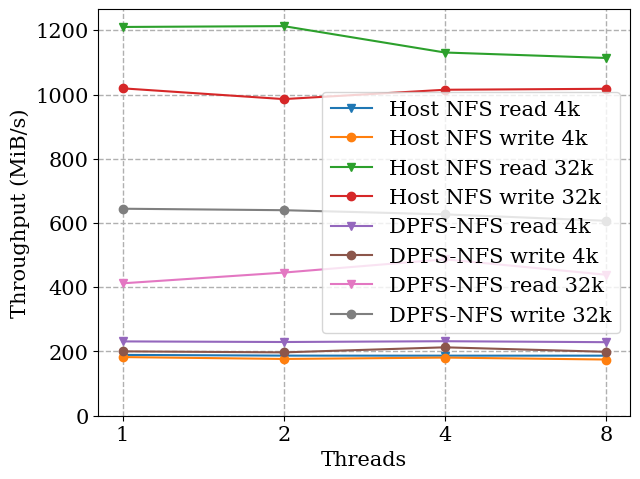

In [11]:
# Multi-core
def plot_multicore(confs, BS, file):
    fig, ax = plt.subplots()

    QD = '128'

    x = s.loc[(s['RW'] == 'randread') & (s['conf'] == 'NFS') & (s['QD'] == QD) & (s['BS'] == BS[0]), 'P'].sort_values()
    for (conf, conf_name) in confs.items():
        for bs in BS:
            d = s.loc[(s['QD'] == QD) & (s['conf'] == conf) & (s['BS'] == bs)].sort_values(by='P')

            ax.plot(x, d.loc[(d['RW'] == 'randread'), 'bw_avg'],
                        markersize=6, marker='v', label=conf_name + "read " + bs)
            ax.plot(x, d.loc[(d['RW'] == 'randwrite'), 'bw_avg'],
                        markersize=6, marker='o', label=conf_name+ "write " + bs)

    fig.tight_layout()
    ax.grid(which='major', linestyle='dashed', linewidth='1')
    ax.set_axisbelow(True)
    ax.legend(loc='best')
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Throughput (MiB/s)")
    ax.set_xlabel("Threads")

    fig.show()
    plt.savefig("./graphs/" + file + "_multicore.pdf", bbox_inches="tight")
    
    
plot_multicore({'NFS': 'Host NFS ', 'VNFS': 'DPFS-NFS '}, ['4k', '32k'], 'nfs_vnfs')

In [12]:
d = s.loc[(s['QD'].isin(['16', '32', '64', '128'])) & (s['P'] == '2') & (s['BS'] == '4k') & (s['RW'] == 'randread')]
nfs = d.loc[(d['conf'] == 'NFS'), 'bw_avg'].mean()
vnfs = d.loc[(d['conf'] == 'VNFS'), 'bw_avg'].mean()
read = (vnfs - nfs) / nfs * 100

d = s.loc[(s['QD'].isin(['16', '32', '64', '128'])) & (s['P'] == '2') & (s['BS'] == '4k') & (s['RW'] == 'randwrite')]
nfs = d.loc[(d['conf'] == 'NFS'), 'bw_avg'].mean()
vnfs = d.loc[(d['conf'] == 'VNFS'), 'bw_avg'].mean()
write = (vnfs - nfs) / nfs * 100
print("At QD>=16,BS=4k, VNFS has " + str(round(read,2)) + "%" + " better read and " + str(round(write,2)) + "% write throughput")

At QD>=16,BS=4k, VNFS has 21.77% better read and 12.96% write throughput


/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/4050006532.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


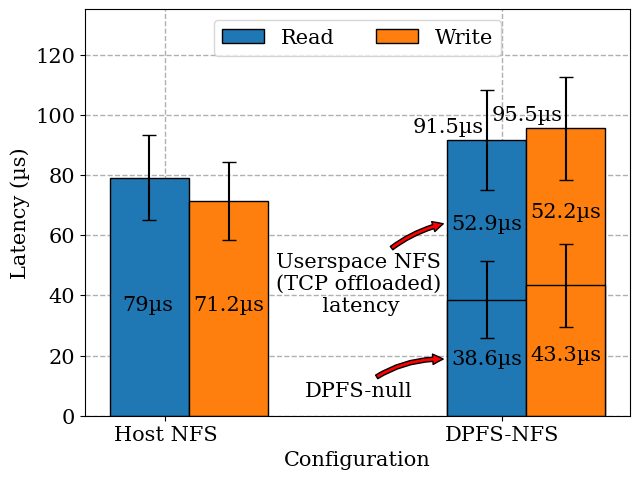

In [16]:
def advanced_latency():
    a_avg = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])), 'clat_avg']
    a_stdev = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])), 'clat_stdev']

    b_avg = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev'), 'clat_avg']
    b_stdev = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev'), 'clat_stdev']

    fig, ax = plt.subplots()

    confs = ["Host NFS", "DPFS-NFS"]
    avg = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randread'), 'clat_avg'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randwrite'), 'clat_avg'],
    }
    stdev = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randread'), 'clat_stdev'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randwrite'), 'clat_stdev'],
    }
    x = np.arange(len(confs))
    width = 0.235
    multiplier = 0.3
    
    for (rw, val) in avg.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, val, width, label=rw, yerr=stdev[rw], capsize=5, edgecolor='black')
        #ax.bar_label(rects, padding=-5, fmt='%.1fµs')
        multiplier += 1
        
    null_avg = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randread'), 'clat_avg'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randwrite'), 'clat_avg'],
    }
    null_stdev = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randread'), 'clat_stdev'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randwrite'), 'clat_stdev'],
    }
    
    multiplier = 0.3
    colors = {"Read": 'tab:blue', "Write": 'tab:orange'}
    for (rw, val) in null_avg.items():
        offset = width * multiplier
        rects = ax.bar(1 + offset, val, yerr=null_stdev[rw], width=width, bottom=0, capsize=5, color=colors[rw], edgecolor='black')
        ax.bar_label(rects, padding=-(val*2), fmt='%.1fµs') # put at bottom
        multiplier += 1
    ax.annotate('DPFS-null', xy=(0.95,18.8), xytext=(0.53, 6.5), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", facecolor='red'))
    ax.annotate('Userspace NFS\n(TCP offloaded)\n       latency', xy=(0.95,64), xytext=(0.445, 34.6), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", facecolor='red'))
    #ax.annotate('Total latency', xy=(0.87,113.5), xytext=(0.49, 93), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", facecolor='red'))
    ax.annotate('52.9µs', xy=(0,0), xytext=(0.965, 62)) # libnfs
    ax.annotate('52.2µs', xy=(0,0), xytext=(1.20, 66)) # libnfs
    ax.annotate('79µs', xy=(0,0), xytext=(-0.01, 35)) # NFS
    ax.annotate('71.2µs', xy=(0,0), xytext=(0.2, 35)) # NFS
    ax.annotate('91.5µs', xy=(0,0), xytext=(0.85, 94)) # total DPFS
    ax.annotate('95.5µs', xy=(0,0), xytext=(1.085, 98)) # total DPFS
    #ax.annotate('DPU', xy=(0,0), xytext=(1.2, 28))
    #ax.annotate('NFS', xy=(0,0), xytext=(0.95, 62))
    #ax.annotate('NFS', xy=(0,0), xytext=(1.2, 67))

    fig.tight_layout()
    ax.grid(which='major', linestyle='dashed', linewidth='1')
    ax.set_axisbelow(True)
    ax.set_ylim(top=135)
    ax.set_xticks(x+width*0.5, confs)
    #ax.set_xlim(left=-0.08, right=1.48)
    ax.legend(loc='upper center', ncols=3)
    ax.set_ylabel("Latency (µs)")
    ax.set_xlabel("Configuration")

    plt.savefig("./graphs/4k_clat.pdf", bbox_inches="tight")
    fig.show()
    
advanced_latency()

#every line different marker
#clean 2

# calc diff DPU 

# send where it says in kernel code that one queue

In [14]:
#clat (usec): min=50, max=2773, avg=63.76, stdev=19.28
#clat (usec): min=50, max=2833, avg=63.91, stdev=16.80
#clat (usec): min=50, max=2852, avg=63.69, stdev=21.88

ram_read_avg = [ 61.35, 61.04, 65.49 ]
ram_read_stdev = [ 19.32, 18.92, 20.01 ]
print("RAM read avg = " + str(np.array(ram_read_avg).astype(float).mean()))
print("RAM read stdev = " + str(np.array(ram_read_stdev).astype(float).mean()))
ram_write_avg = [ 69.62, 69.22, 73.53 ]
ram_write_stdev = [ 19.78, 21.79, 21.99 ]
print("RAM write avg = " + str(np.array(ram_write_avg).astype(float).mean()))
print("RAM write stdev = " + str(np.array(ram_write_stdev).astype(float).mean()))

nfs_read_avg = [ 71.14367, 71.18850, 71.13393 ]
nfs_read_stdev = [ 9.53701, 10.38603, 10.16720 ]
print("NFS read avg = " + str(np.array(nfs_read_avg).astype(float).mean()))
print("NFS read stdev = " + str(np.array(nfs_read_stdev).astype(float).mean()))
nfs_write_avg = [ 76.93398, 74.00317, 77.16800]
nfs_write_stdev = [ 9.57086, 20.15387, 8.35093]
print("NFS write avg = " + str(np.array(nfs_write_avg).astype(float).mean()))
print("NFS write stdev = " + str(np.array(nfs_write_stdev).astype(float).mean()))


print(1 - np.array(ram_read_avg).astype(float).mean() / np.array(nfs_read_avg).astype(float).mean())
print(1 - np.array(ram_write_avg).astype(float).mean() / np.array(nfs_write_avg).astype(float).mean())

RAM read avg = 62.626666666666665
RAM read stdev = 19.416666666666668
RAM write avg = 70.79
RAM write stdev = 21.186666666666667
NFS read avg = 71.15536666666668
NFS read stdev = 10.03008
NFS write avg = 76.03505
NFS write stdev = 12.691886666666667
0.11986024947286733
0.06898200237916585


/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_51745/1089955524.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


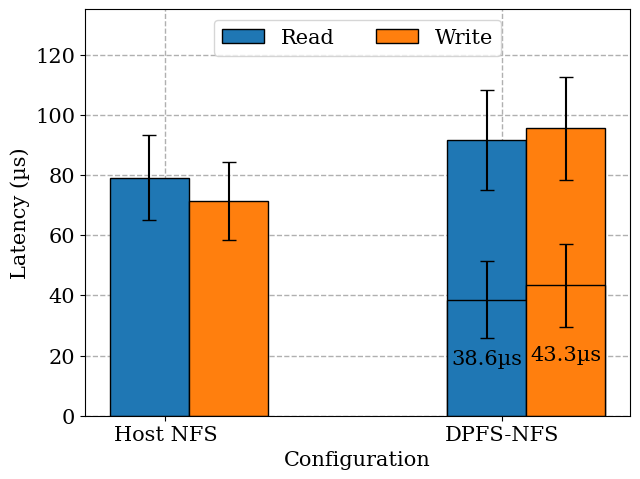

In [15]:
def advanced_latency():
    a_avg = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])), 'clat_avg']
    a_stdev = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])), 'clat_stdev']

    b_avg = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev'), 'clat_avg']
    b_stdev = s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev'), 'clat_stdev']

    fig, ax = plt.subplots()

    confs = ["Host NFS", "DPFS-NFS"]
    avg = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randread'), 'clat_avg'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randwrite'), 'clat_avg'],
    }
    stdev = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randread'), 'clat_stdev'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'].isin(['NFS', 'VNFS'])) & (s['RW'] == 'randwrite'), 'clat_stdev'],
    }
    x = np.arange(len(confs))
    width = 0.235
    multiplier = 0.3
    
    for (rw, val) in avg.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, val, width, label=rw, yerr=stdev[rw], capsize=5, edgecolor='black')
        #ax.bar_label(rects, padding=-5, fmt='%.1fµs')
        multiplier += 1
        
    null_avg = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randread'), 'clat_avg'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randwrite'), 'clat_avg'],
    }
    null_stdev = {
        "Read": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randread'), 'clat_stdev'],
        "Write": s.loc[(s['QD'] == '1') & (s['P'] == '1') & (s['BS'] == '4k') & (s['conf'] == 'nulldev') & (s['RW'] == 'randwrite'), 'clat_stdev'],
    }
    
    multiplier = 0.3
    colors = {"Read": 'tab:blue', "Write": 'tab:orange'}
    for (rw, val) in null_avg.items():
        offset = width * multiplier
        rects = ax.bar(1 + offset, val, yerr=null_stdev[rw], width=width, bottom=0, capsize=5, color=colors[rw], edgecolor='black')
        ax.bar_label(rects, padding=-(val*2), fmt='%.1fµs') # put at bottom
        multiplier += 1
    # ax.annotate('DPFS-null', xy=(0.95,18.8), xytext=(0.53, 6.5), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", facecolor='red'))
    # ax.annotate('Userspace NFS\n(TCP offloaded)\n       latency', xy=(0.95,64), xytext=(0.445, 34.6), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", facecolor='red'))
    # #ax.annotate('Total latency', xy=(0.87,113.5), xytext=(0.49, 93), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", facecolor='red'))
    # ax.annotate('52.9µs', xy=(0,0), xytext=(0.965, 62)) # libnfs
    # ax.annotate('52.2µs', xy=(0,0), xytext=(1.20, 66)) # libnfs
    # ax.annotate('79µs', xy=(0,0), xytext=(-0.01, 35)) # NFS
    # ax.annotate('71.2µs', xy=(0,0), xytext=(0.2, 35)) # NFS
    # ax.annotate('91.5µs', xy=(0,0), xytext=(0.85, 94)) # total DPFS
    # ax.annotate('95.5µs', xy=(0,0), xytext=(1.085, 98)) # total DPFS
    #ax.annotate('DPU', xy=(0,0), xytext=(1.2, 28))
    #ax.annotate('NFS', xy=(0,0), xytext=(0.95, 62))
    #ax.annotate('NFS', xy=(0,0), xytext=(1.2, 67))

    fig.tight_layout()
    ax.grid(which='major', linestyle='dashed', linewidth='1')
    ax.set_axisbelow(True)
    ax.set_ylim(top=135)
    ax.set_xticks(x+width*0.5, confs)
    #ax.set_xlim(left=-0.08, right=1.48)
    ax.legend(loc='upper center', ncols=3)
    ax.set_ylabel("Latency (µs)")
    ax.set_xlabel("Configuration")

    plt.savefig("./graphs/4k_clat.pdf", bbox_inches="tight")
    fig.show()
    
advanced_latency()

#every line different marker
#clean 2

# calc diff DPU 

# send where it says in kernel code that one queue